In [1]:
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import gym
import os
import abc
from collections import deque, namedtuple

import warnings
import random
from scipy.io import savemat
import matplotlib.pyplot as plt
%matplotlib inline

```python
# https://github.com/chainer/chainerrl/issues/164
# gym.undo_logger_setup()
```

In [2]:
class args:
    mode = 'train'
    env = 'Pendulum-v0'
    hidden1 = 400
    hidden2 = 300
    rate = 0.001 # learning rate
    prate = 0.0001 # policy net learning rate
    warmup = 100
    discount = 0.99
    bsize = 64
    rmsize = 6000000 # memory size
    window_length = 1
    tau = 0.001 # moving average for target network
    ou_theta = 0.15 # noise theta
    ou_sigma = 0.2 # noise sigma
    ou_mu = 0.0 # noise mu
    validate_episodes = 20 # how many episodes to perform during validate experiment
    max_episode_length = 500
    validate_steps = 2000 # how many steps to perform a validate experiment
    output = 'output'
    debug = True
    init_w = 0.003
    train_iter = 200000 # train iters each timestep
    epsilon = 50000 # linear decay of exploration policy
    seed = -1
    resume = 'default' # Resuming model path for testing

In [3]:
def get_output_folder(parent_dir, env_name):
    os.makedirs(parent_dir, exist_ok=True)
    experiment_id = 0
    for folder_name in os.listdir(parent_dir):
        if not os.path.isdir(os.path.join(parent_dir, folder_name)):
            continue
        try:
            folder_name = int(folder_name.split('-run')[-1])
            if folder_name > experiment_id:
                experiment_id = folder_name
        except:
            pass
    experiment_id += 1

    parent_dir = os.path.join(parent_dir, env_name)
    parent_dir = parent_dir + '-run{}'.format(experiment_id)
    os.makedirs(parent_dir, exist_ok=True)
    return parent_dir

args.output = get_output_folder(args.output, args.env)
args.output

'output\\Pendulum-v0-run18'

In [4]:
if args.resume == 'default':
    args.resume = 'output/{}-run0'.format(args.env)
args.resume

'output/Pendulum-v0-run0'

In [5]:
env = gym.make(args.env)
env

<TimeLimit<PendulumEnv<Pendulum-v0>>>

In [6]:
# https://github.com/openai/gym/blob/master/gym/core.py
class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)
    
    
env = NormalizedEnv(gym.make(args.env))
env

<NormalizedEnv<TimeLimit<PendulumEnv<Pendulum-v0>>>>

In [7]:
if args.seed > 0:
    np.random.seed(args.seed)
    env.seed(args.seed)

In [8]:
nb_states = env.observation_space.shape[0]
nb_actions = env.action_space.shape[0]
nb_states, nb_actions

(3, 1)

In [9]:
# utils

USE_CUDA = torch.cuda.is_available()
FLOAT = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor


def prRed(prt): print("\033[91m {}\033[00m" .format(prt))
def prGreen(prt): print("\033[92m {}\033[00m" .format(prt))
def prYellow(prt): print("\033[93m {}\033[00m" .format(prt))
def prLightPurple(prt): print("\033[94m {}\033[00m" .format(prt))
def prPurple(prt): print("\033[95m {}\033[00m" .format(prt))
def prCyan(prt): print("\033[96m {}\033[00m" .format(prt))
def prLightGray(prt): print("\033[97m {}\033[00m" .format(prt))
def prBlack(prt): print("\033[98m {}\033[00m" .format(prt))

    
def to_numpy(var):
    return var.cpu().data.numpy() if USE_CUDA else var.data.numpy()

In [10]:
def soft_update(target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - tau) + param.data * tau
        )
        

def hard_update(target, source):
    soft_update(target, source, 1.0)

In [11]:
# [reference] https://github.com/matthiasplappert/keras-rl/blob/master/rl/random.py

class RandomProcess(object):

    def reset_states(self):
        pass
    
    
class AnnealedGaussianProcess(RandomProcess):
    def __init__(self, mu, sigma, sigma_min, n_steps_annealing):
        self.mu = mu
        self.sigma = sigma
        self.n_steps = 0

        if sigma_min is not None:
            self.m = -float(sigma - sigma_min) / float(n_steps_annealing)
            self.c = sigma
            self.sigma_min = sigma_min
        else:
            self.m = 0.
            self.c = sigma
            self.sigma_min = sigma

    @property
    def current_sigma(self):
        sigma = max(self.sigma_min, self.m * float(self.n_steps) + self.c)
        return sigma

In [12]:
class GaussianWhiteNoiseProcess(AnnealedGaussianProcess):
    def __init__(self, mu=0., sigma=1., sigma_min=None, n_steps_annealing=1000, size=1):
        super(GaussianWhiteNoiseProcess, self).__init__(mu=mu, sigma=sigma, sigma_min=sigma_min, n_steps_annealing=n_steps_annealing)
        self.size = size

    def sample(self):
        sample = np.random.normal(self.mu, self.current_sigma, self.size)
        self.n_steps += 1
        return sample

# Based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckProcess(AnnealedGaussianProcess):
    def __init__(self, theta, mu=0., sigma=1., dt=1e-2, size=1, sigma_min=None, n_steps_annealing=1000):
        super().__init__(
            mu=mu, 
            sigma=sigma, 
            sigma_min=sigma_min, 
            n_steps_annealing=n_steps_annealing)
        self.theta = theta
        self.mu = mu
        self.dt = dt
        self.size = size
        self.reset_states()

    def sample(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.current_sigma * np.sqrt(self.dt) * np.random.normal(size=self.size)
        self.x_prev = x
        self.n_steps += 1
        return x

    def reset_states(self):
        self.x_prev = np.random.normal(self.mu,self.current_sigma,self.size)

In [13]:
# memory
# [reference] https://github.com/matthiasplappert/keras-rl/blob/master/rl/memory.py

# This is to be understood as a transition: Given `state0`, performing `action`
# yields `reward` and results in `state1`, which might be `terminal`.
Experience = namedtuple('Experience', 'state0, action, reward, state1, terminal1')


def sample_batch_indexes(low, high, size):
    if high - low >= size:
        r = range(low, high)
        batch_idxs = random.sample(r, size)
    else:
        warnings.warn('Not enough entries to sample without replacement. '
                      'Consider increasing your warm-up phase to avoid oversampling!')
        batch_idxs = np.random.random_integers(low, high-1, size=size_)
    assert len(batch_idxs) == size
    return batch_idxs


class RingBuffer(object):
    """ 원형 Queue """
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.start = 0
        self.length = 0
        self.data = [None for _ in range(maxlen)]
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        if idx < 0 or idx >= self.length:
            raise KeyError()
        return self.data[(self.start + idx) % self.maxlen]
    
    def append(self, v):
        if self.length < self.maxlen:
            # We have space, simply increases the length.
            self.length += 1
        elif self.length == self.maxlen:
            # No space, "remove" the first item.
            self.start = (self.start + 1) % self.maxlen
        else:
            raise RuntimeError()
        self.data[(self.start + self.length - 1) % self.maxlen] = v
        

def zeroed_observation(observation):
    if hasattr(observation, 'shape'):
        return np.zeros(observation.shape)
    elif hasattr(observation, '__iter__'):
        out = []
        for x in observation:
            out.append(zeroed_observation(x))
        return out
    else:
        return 0.0

In [14]:
class Memory(object):
    
    def __init__(self, window_length, ignore_episode_boundaries=False):
        self.window_length = window_length
        self.ignore_episode_boundaries = ignore_episode_boundaries
        self.recent_observations = deque(maxlen=window_length)
        self.recent_terminals = deque(maxlen=window_length)
        
    def sample(self, batch_size, batch_idxs=None):
        raise NotImplementedError()
        
    def append(self, observation, terminal):
        self.recent_observations.append(observation)
        self.recent_terminals.append(terminal)
        
    def get_state(self, observation, idx):
        state = [observation]
        for offset in range(self.window_length - 1):
            current_idx = idx - offset
            current_terminal = self.recent_terminals[current_idx-1] if current_idx-1 >= 0 else False
            if current_idx < 0 or (not self.ignore_episode_boundaries and current_terminal):
                break
            state.insert(0, self.recent_observations[current_idx])
        while len(state) < self.window_length:
            state.insert(0, zeroed_observation(state[0]))
        return state
        
    def get_recent_state(self, current_observation):
        idx = len(self.recent_observations) - 1
        state = self.get_state(current_observation, idx)
        return state
    
    def get_config(self):
        config = dict(window_length=self.window_length,
                      ignore_episode_boundaries=self.ignore_episode_boundaries)
        return config

In [15]:
class SequentialMemory(Memory):
    
    def __init__(self, limit, **kwargs):
        super().__init__(**kwargs)
        self.limit = limit
        # deque는 편리해보이지만 random access에서 너무 느리다고 함.
        # 위에서 구현한 RingBuffer를 사용
        self.actions = RingBuffer(limit)
        self.rewards = RingBuffer(limit)
        self.terminals = RingBuffer(limit)
        self.observations = RingBuffer(limit)
        
    def sample(self, batch_size, batch_idxs=None):
        if batch_idxs is None:
            batch_idxs = sample_batch_indexes(0, self.nb_entries - 1, size=batch_size)
        batch_idxs = np.array(batch_idxs) + 1
        assert np.min(batch_idxs) >= 1
        assert np.max(batch_idxs) < self.nb_entries
        assert len(batch_idxs) == batch_size
        
        # Create Experiences
        experiences = []
        for idx in batch_idxs:
            terminal0 = self.terminals[idx-2] if idx >= 2 else False
            while terminal0:
                idx = sample_batch_indexes(1, self.nb_entries, size=1)[0]
                terminal0 = self.terminals[idx-2] if idx >= 2 else False
            assert 1 <= idx < self.nb_entries
            
            state0 = self.get_state(self.observations[idx-1], idx-2)
            action = self.actions[idx-1]
            reward = self.rewards[idx-1]
            terminal1 = self.terminals[idx-1]
            
            state1 = [np.copy(x) for x in state0[1:]]
            state1.append(self.observations[idx])
            
            assert len(state0) == self.window_length
            assert len(state1) == len(state0)
            experiences.append(Experience(state0=state0, action=action, reward=reward,
                                          state1=state1, terminal1=terminal1))
        assert len(experiences) == batch_size
        return experiences
            
    def sample_and_split(self, batch_size, batch_idxs=None):
        experiences = self.sample(batch_size, batch_idxs)

        state0_batch = []
        reward_batch = []
        action_batch = []
        terminal1_batch = []
        state1_batch = []
        for e in experiences:
            state0_batch.append(e.state0)
            state1_batch.append(e.state1)
            reward_batch.append(e.reward)
            action_batch.append(e.action)
            terminal1_batch.append(0. if e.terminal1 else 1.)

        # Prepare and validate parameters.
        state0_batch = np.array(state0_batch).reshape(batch_size,-1)
        state1_batch = np.array(state1_batch).reshape(batch_size,-1)
        terminal1_batch = np.array(terminal1_batch).reshape(batch_size,-1)
        reward_batch = np.array(reward_batch).reshape(batch_size,-1)
        action_batch = np.array(action_batch).reshape(batch_size,-1)

        return state0_batch, action_batch, reward_batch, state1_batch, terminal1_batch
    
    def append(self, observation, action, reward, terminal, training=True):
        super().append(observation, terminal)
        if training:
            self.observations.append(observation)
            self.actions.append(action)
            self.rewards.append(reward)
            self.terminals.append(terminal)
    
    @property
    def nb_entries(self):
        return len(self.observations)
    
    def get_config(self):
        config = super().get_config()
        config['limit'] = self.limit
        return config

In [16]:
# model.py

def fanin_init(size, fanin=None):
    fanin = fanin or size[0]
    v = 1. / np.sqrt(fanin)
    return torch.Tensor(size).uniform_(-v, v)

class Actor(nn.Module):
    def __init__(self, nb_states, nb_actions, hidden1=400, hidden2=300, init_w=3e-3):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(nb_states, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, nb_actions)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.init_weights(init_w)
    
    def init_weights(self, init_w):
        self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())
        self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())
        self.fc3.weight.data.uniform_(-init_w, init_w)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.tanh(out)
        return out

class Critic(nn.Module):
    def __init__(self, nb_states, nb_actions, hidden1=400, hidden2=300, init_w=3e-3):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(nb_states, hidden1)
        self.fc2 = nn.Linear(hidden1+nb_actions, hidden2)
        self.fc3 = nn.Linear(hidden2, 1)
        self.relu = nn.ReLU()
        self.init_weights(init_w)
    
    def init_weights(self, init_w):
        self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())
        self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())
        self.fc3.weight.data.uniform_(-init_w, init_w)
    
    def forward(self, xs):
        x, a = xs
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(torch.cat([out,a],1))
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [17]:
# ddpg.py

criterion = nn.MSELoss()

class DDPG(object):
    def __init__(self, nb_states, nb_actions, args):
        
        if args.seed > 0:
            self.seed(args.seed)

        self.nb_states = nb_states
        self.nb_actions= nb_actions
        
        # Create Actor and Critic Network
        net_cfg = {
            'hidden1':args.hidden1, 
            'hidden2':args.hidden2, 
            'init_w':args.init_w
        }
        self.actor = Actor(self.nb_states, self.nb_actions, **net_cfg)
        self.actor_target = Actor(self.nb_states, self.nb_actions, **net_cfg)
        self.actor_optim  = Adam(self.actor.parameters(), lr=args.prate)

        self.critic = Critic(self.nb_states, self.nb_actions, **net_cfg)
        self.critic_target = Critic(self.nb_states, self.nb_actions, **net_cfg)
        self.critic_optim  = Adam(self.critic.parameters(), lr=args.rate)

        hard_update(self.actor_target, self.actor) # Make sure target is with the same weight
        hard_update(self.critic_target, self.critic)
        
        #Create replay buffer
        self.memory = SequentialMemory(limit=args.rmsize, window_length=args.window_length)
        self.random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=args.ou_theta, mu=args.ou_mu, sigma=args.ou_sigma)

        # Hyper-parameters
        self.batch_size = args.bsize
        self.tau = args.tau
        self.discount = args.discount
        self.depsilon = 1.0 / args.epsilon

        # 
        self.epsilon = 1.0
        self.s_t = None # Most recent state
        self.a_t = None # Most recent action
        self.is_training = True

        # 
        if USE_CUDA: self.cuda()

    def update_policy(self):
        # Sample batch
        sample = self.memory.sample_and_split(self.batch_size)
        state_batch = torch.FloatTensor(sample[0])
        action_batch = torch.FloatTensor(sample[1])
        reward_batch = torch.FloatTensor(sample[2])
        next_state_batch = torch.FloatTensor(sample[3])
        terminal_batch = torch.FloatTensor(sample[4])
            
        # Prepare for the target q batch
        with torch.no_grad():
            next_q_values = self.critic_target([
                next_state_batch,
                self.actor_target(next_state_batch),
            ])

            target_q_batch = reward_batch + \
                self.discount * terminal_batch * next_q_values

        # Critic update
        self.critic.zero_grad()

        q_batch = self.critic([state_batch, action_batch])
        
        value_loss = criterion(q_batch, target_q_batch)
        value_loss.backward()
        self.critic_optim.step()

        # Actor update
        self.actor.zero_grad()

        policy_loss = -self.critic([state_batch, self.actor(state_batch)])

        policy_loss = policy_loss.mean()
        policy_loss.backward()
        self.actor_optim.step()

        # Target update
        soft_update(self.actor_target, self.actor, self.tau)
        soft_update(self.critic_target, self.critic, self.tau)

    def eval(self):
        self.actor.eval()
        self.actor_target.eval()
        self.critic.eval()
        self.critic_target.eval()

    def cuda(self):
        self.actor.cuda()
        self.actor_target.cuda()
        self.critic.cuda()
        self.critic_target.cuda()

    def observe(self, r_t, s_t1, done):
        if self.is_training:
            self.memory.append(self.s_t, self.a_t, r_t, done)
            self.s_t = s_t1

    def random_action(self):
        action = np.random.uniform(-1.,1.,self.nb_actions)
        self.a_t = action
        return action

    def select_action(self, s_t, decay_epsilon=True):
        action = to_numpy(
            self.actor(torch.FloatTensor(s_t))
        )
        action += self.is_training*max(self.epsilon, 0)*self.random_process.sample()
        action = np.clip(action, -1., 1.)

        if decay_epsilon:
            self.epsilon -= self.depsilon
        
        self.a_t = action
        return action

    def reset(self, obs):
        self.s_t = obs
        self.random_process.reset_states()

    def load_weights(self, output):
        if output is None: return

        self.actor.load_state_dict(
            torch.load('{}/actor.pkl'.format(output))
        )

        self.critic.load_state_dict(
            torch.load('{}/critic.pkl'.format(output))
        )


    def save_model(self,output):
        torch.save(
            self.actor.state_dict(),
            '{}/actor.pkl'.format(output)
        )
        torch.save(
            self.critic.state_dict(),
            '{}/critic.pkl'.format(output)
        )

    def seed(self,s):
        torch.manual_seed(s)
        if USE_CUDA:
            torch.cuda.manual_seed(s)

In [18]:
agent = DDPG(nb_states, nb_actions, args)

In [19]:
class Evaluator(object):

    def __init__(self, num_episodes, interval, save_path='', max_episode_length=None):
        self.num_episodes = num_episodes
        self.max_episode_length = max_episode_length
        self.interval = interval
        self.save_path = save_path
        self.results = np.array([]).reshape(num_episodes,0)

    def __call__(self, env, policy, debug=False, visualize=False, save=True):

        self.is_training = False
        observation = None
        result = []

        for episode in range(self.num_episodes):

            # reset at the start of episode
            observation = env.reset()
            episode_steps = 0
            episode_reward = 0.
                
            assert observation is not None

            # start episode
            done = False
            while not done:
                # basic operation, action ,reward, blablabla ...
                action = policy(observation)

                observation, reward, done, info = env.step(action)
                if self.max_episode_length and episode_steps >= self.max_episode_length -1:
                    done = True
                
                if visualize:
                    env.render(mode='human')

                # update
                episode_reward += reward
                episode_steps += 1

            if debug: prYellow('[Evaluate] #Episode{}: episode_reward:{}'.format(episode,episode_reward))
            result.append(episode_reward)

        result = np.array(result).reshape(-1,1)
        self.results = np.hstack([self.results, result])

        if save:
            self.save_results('{}/validate_reward'.format(self.save_path))
        return np.mean(result)

    def save_results(self, fn):

        y = np.mean(self.results, axis=0)
        error=np.std(self.results, axis=0)
                    
        x = range(0,self.results.shape[1]*self.interval,self.interval)
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        plt.xlabel('Timestep')
        plt.ylabel('Average Reward')
        ax.errorbar(x, y, yerr=error, fmt='-o')
        plt.savefig(fn+'.png')
        savemat(fn+'.mat', {'reward':self.results})

In [20]:
evaluate = Evaluator(args.validate_episodes, 
    args.validate_steps, args.output, max_episode_length=args.max_episode_length)

In [21]:
def train(num_iterations, agent, env,  evaluate, validate_steps, output, max_episode_length=None, debug=False):

    agent.is_training = True
    step = episode = episode_steps = 0
    episode_reward = 0.
    observation = None
    while step < num_iterations:
        # reset if it is the start of episode
        if observation is None:
            observation = deepcopy(env.reset())
            agent.reset(observation)

        # agent pick action ...
        if step <= args.warmup:
            action = agent.random_action()
        else:
            action = agent.select_action(observation)
        
        # env response with next_observation, reward, terminate_info
        observation2, reward, done, info = env.step(action)
        observation2 = deepcopy(observation2)
        if max_episode_length and episode_steps >= max_episode_length -1:
            done = True

        # agent observe and update policy
        agent.observe(reward, observation2, done)
        if step > args.warmup :
            agent.update_policy()
        
        # [optional] evaluate
        if evaluate is not None and validate_steps > 0 and step % validate_steps == 0:
            policy = lambda x: agent.select_action(x, decay_epsilon=False)
            validate_reward = evaluate(env, policy, debug=False, visualize=False)
            if debug: prYellow('[Evaluate] Step_{:07d}: mean_reward:{}'.format(step, validate_reward))

        # [optional] save intermideate model
        if step % int(num_iterations/3) == 0:
            agent.save_model(output)

        # update 
        step += 1
        episode_steps += 1
        episode_reward += reward
        observation = deepcopy(observation2)

        if done: # end of episode
            if debug: prGreen('#{}: episode_reward:{} steps:{}'.format(episode,episode_reward,step))

            agent.memory.append(
                observation,
                agent.select_action(observation),
                0., False
            )

            # reset
            observation = None
            episode_steps = 0
            episode_reward = 0.
            episode += 1

 [Evaluate] Step_0000000: mean_reward:-1384.6690824273453
 #0: episode_reward:-9.904719194854163 steps:2
 #1: episode_reward:-1158.7912749690258 steps:202
 #2: episode_reward:-1607.8924947806747 steps:402
 #3: episode_reward:-1518.7492962645595 steps:602
 #4: episode_reward:-1187.2390187175474 steps:802
 #5: episode_reward:-1395.8559548629205 steps:1002
 #6: episode_reward:-1601.391937734348 steps:1202
 #7: episode_reward:-1338.1747312957154 steps:1402
 #8: episode_reward:-1189.4117875068855 steps:1602
 #9: episode_reward:-1598.6644753404003 steps:1802
 [Evaluate] Step_0002000: mean_reward:-1422.8588305355838
 #10: episode_reward:-1572.9564774449755 steps:2002
 #11: episode_reward:-1562.323250550063 steps:2202
 #12: episode_reward:-1389.1680283782935 steps:2402
 #13: episode_reward:-1457.3814842041863 steps:2602
 #14: episode_reward:-1581.1156277456487 steps:2802
 #15: episode_reward:-1178.5979097533118 steps:3002
 #16: episode_reward:-1227.1696736501492 steps:3202
 #17: episode_reward

 #119: episode_reward:-821.30536619281 steps:23802
 [Evaluate] Step_0024000: mean_reward:-705.0115642746414
 #120: episode_reward:-1466.0216134547459 steps:24002
 #121: episode_reward:-1495.7346680275814 steps:24202
 #122: episode_reward:-136.5251561598708 steps:24402
 #123: episode_reward:-536.2155669609448 steps:24602
 #124: episode_reward:-142.93182280374157 steps:24802
 #125: episode_reward:-400.41415753570277 steps:25002
 #126: episode_reward:-140.65762988038384 steps:25202
 #127: episode_reward:-1439.8857435957568 steps:25402
 #128: episode_reward:-1533.8867910051638 steps:25602
 #129: episode_reward:-1541.1552509628416 steps:25802
 [Evaluate] Step_0026000: mean_reward:-587.300576988094
 #130: episode_reward:-271.7892382657353 steps:26002
 #131: episode_reward:-673.5866023807445 steps:26202
 #132: episode_reward:-272.9889532440824 steps:26402
 #133: episode_reward:-551.1681540790418 steps:26602
 #134: episode_reward:-134.06761033578985 steps:26802
 #135: episode_reward:-514.76263

C:\Users\jinma\AppData\Local\Continuum\anaconda3\envs\basic\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


 [Evaluate] Step_0040000: mean_reward:-234.6039688770661
 #200: episode_reward:-5.0444111839389025 steps:40002
 #201: episode_reward:-241.22380514444194 steps:40202
 #202: episode_reward:-949.2788690741654 steps:40402
 #203: episode_reward:-900.4878449738743 steps:40602
 #204: episode_reward:-375.38461261018574 steps:40802
 #205: episode_reward:-5.745713316377903 steps:41002
 #206: episode_reward:-133.8560594989912 steps:41202
 #207: episode_reward:-646.5327764201141 steps:41402
 #208: episode_reward:-266.23353910789626 steps:41602
 #209: episode_reward:-853.997564075325 steps:41802
 [Evaluate] Step_0042000: mean_reward:-296.8495233085879
 #210: episode_reward:-910.4806688925885 steps:42002
 #211: episode_reward:-369.3537948047069 steps:42202
 #212: episode_reward:-124.03903213577479 steps:42402
 #213: episode_reward:-119.02546685691115 steps:42602
 #214: episode_reward:-123.04822433250233 steps:42802
 #215: episode_reward:-135.33853961125317 steps:43002
 #216: episode_reward:-137.1043

 #317: episode_reward:-674.0867896438504 steps:63402
 #318: episode_reward:-133.78106564985052 steps:63602
 #319: episode_reward:-525.0201402962332 steps:63802
 [Evaluate] Step_0064000: mean_reward:-333.764469448662
 #320: episode_reward:-1110.4215960798938 steps:64002
 #321: episode_reward:-9.862826619614806 steps:64202
 #322: episode_reward:-132.3355898614731 steps:64402
 #323: episode_reward:-265.45836577150345 steps:64602
 #324: episode_reward:-120.77350405977064 steps:64802
 #325: episode_reward:-134.66802582529166 steps:65002
 #326: episode_reward:-9.261291249921177 steps:65202
 #327: episode_reward:-622.8546573036206 steps:65402
 #328: episode_reward:-260.7821629903512 steps:65602
 #329: episode_reward:-138.67186725624643 steps:65802
 [Evaluate] Step_0066000: mean_reward:-352.0110143720352
 #330: episode_reward:-133.79139245138037 steps:66002
 #331: episode_reward:-256.40895801107354 steps:66202
 #332: episode_reward:-134.04715497091493 steps:66402
 #333: episode_reward:-909.189

 #433: episode_reward:-128.640362768311 steps:86602
 #434: episode_reward:-251.98885148397252 steps:86802
 #435: episode_reward:-135.1278023089108 steps:87002
 #436: episode_reward:-258.8889225840664 steps:87202
 #437: episode_reward:-368.3994839134173 steps:87402
 #438: episode_reward:-139.00515873830716 steps:87602
 #439: episode_reward:-261.12864548186633 steps:87802
 [Evaluate] Step_0088000: mean_reward:-173.08433204968122
 #440: episode_reward:-239.46774825347075 steps:88002
 #441: episode_reward:-259.33305822307057 steps:88202
 #442: episode_reward:-249.01879578378978 steps:88402
 #443: episode_reward:-129.25526320014873 steps:88602
 #444: episode_reward:-365.15246385813003 steps:88802
 #445: episode_reward:-143.03055061073565 steps:89002
 #446: episode_reward:-259.8409106171918 steps:89202
 #447: episode_reward:-135.276815954122 steps:89402
 #448: episode_reward:-253.74100774443005 steps:89602
 #449: episode_reward:-134.65760614335642 steps:89802
 [Evaluate] Step_0090000: mean_r

 [Evaluate] Step_0110000: mean_reward:-111.76043031681357
 #550: episode_reward:-120.29076188274114 steps:110002
 #551: episode_reward:-227.19931162336596 steps:110202
 #552: episode_reward:-117.11629237698739 steps:110402
 #553: episode_reward:-252.72205310485285 steps:110602
 #554: episode_reward:-120.78364165812998 steps:110802
 #555: episode_reward:-235.38338852934356 steps:111002
 #556: episode_reward:-249.1589127637977 steps:111202
 #557: episode_reward:-126.86473195641658 steps:111402
 #558: episode_reward:-128.19648563874566 steps:111602
 #559: episode_reward:-128.97790600531988 steps:111802
 [Evaluate] Step_0112000: mean_reward:-172.9444387276581
 #560: episode_reward:-121.18261814717997 steps:112002
 #561: episode_reward:-228.0533063750834 steps:112202
 #562: episode_reward:-127.01893726651973 steps:112402
 #563: episode_reward:-241.9673847763091 steps:112602
 #564: episode_reward:-0.8126476940816422 steps:112802
 #565: episode_reward:-122.97198064215385 steps:113002
 #566: e

 #664: episode_reward:-124.35970104009708 steps:132802
 #665: episode_reward:-129.94598812872084 steps:133002
 #666: episode_reward:-239.24068706509271 steps:133202
 #667: episode_reward:-127.90815305716956 steps:133402
 #668: episode_reward:-376.60897044567054 steps:133602
 #669: episode_reward:-123.3445747457078 steps:133802
 [Evaluate] Step_0134000: mean_reward:-145.1599021754987
 #670: episode_reward:-118.77323445913504 steps:134002
 #671: episode_reward:-261.3099180040595 steps:134202
 #672: episode_reward:-119.62645168313428 steps:134402
 #673: episode_reward:-126.00665083025696 steps:134602
 #674: episode_reward:-242.19262733296674 steps:134802
 #675: episode_reward:-275.69303354892617 steps:135002
 #676: episode_reward:-236.6227683118782 steps:135202
 #677: episode_reward:-129.25165072685405 steps:135402
 #678: episode_reward:-121.29008692020557 steps:135602
 #679: episode_reward:-128.10230086923025 steps:135802
 [Evaluate] Step_0136000: mean_reward:-173.71900991063876
 #680: e

 [Evaluate] Step_0156000: mean_reward:-125.57147793908969
 #780: episode_reward:-232.37554218119712 steps:156002
 #781: episode_reward:-126.04247396049583 steps:156202
 #782: episode_reward:-130.36245472157927 steps:156402
 #783: episode_reward:-129.49356638149501 steps:156602
 #784: episode_reward:-124.41206352048657 steps:156802
 #785: episode_reward:-129.16398236087895 steps:157002
 #786: episode_reward:-127.41682165681574 steps:157202
 #787: episode_reward:-247.17679576644514 steps:157402
 #788: episode_reward:-123.1954473752513 steps:157602
 #789: episode_reward:-243.0186827352077 steps:157802
 [Evaluate] Step_0158000: mean_reward:-119.23366412245464
 #790: episode_reward:-126.13926195362545 steps:158002
 #791: episode_reward:-5.100093798238175 steps:158202
 #792: episode_reward:-340.1710866320071 steps:158402
 #793: episode_reward:-245.73109556185037 steps:158602
 #794: episode_reward:-239.82477762985508 steps:158802
 #795: episode_reward:-125.38580813379251 steps:159002
 #796: e

 #894: episode_reward:-233.10907677967222 steps:178802
 #895: episode_reward:-126.69582182705501 steps:179002
 #896: episode_reward:-229.75449685547125 steps:179202
 #897: episode_reward:-4.272405128782303 steps:179402
 #898: episode_reward:-265.8935534463646 steps:179602
 #899: episode_reward:-120.47443308978971 steps:179802
 [Evaluate] Step_0180000: mean_reward:-159.44789742127062
 #900: episode_reward:-122.26611155682748 steps:180002
 #901: episode_reward:-118.43822759374264 steps:180202
 #902: episode_reward:-222.79351390885682 steps:180402
 #903: episode_reward:-122.32958330847433 steps:180602
 #904: episode_reward:-229.58267101656213 steps:180802
 #905: episode_reward:-238.34175476376322 steps:181002
 #906: episode_reward:-374.8971948116749 steps:181202
 #907: episode_reward:-126.7218447657012 steps:181402
 #908: episode_reward:-363.5699989952575 steps:181602
 #909: episode_reward:-122.27246426570572 steps:181802
 [Evaluate] Step_0182000: mean_reward:-125.14106548418349
 #910: ep

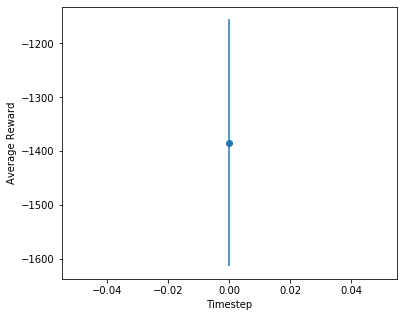

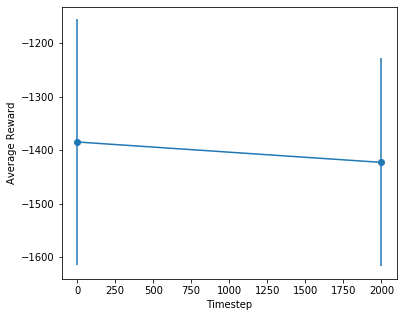

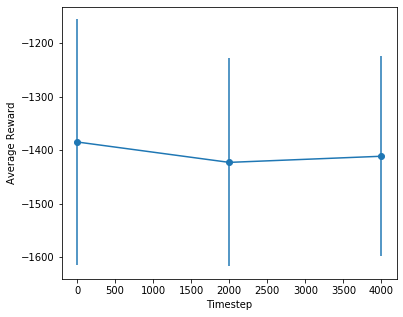

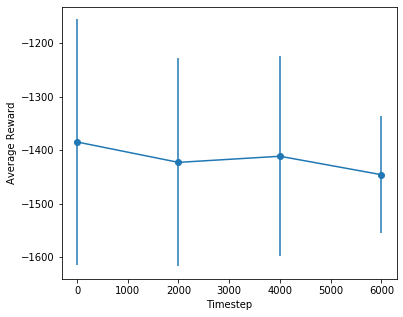

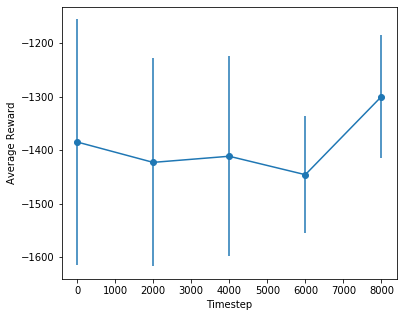

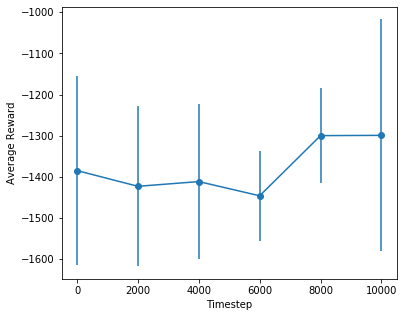

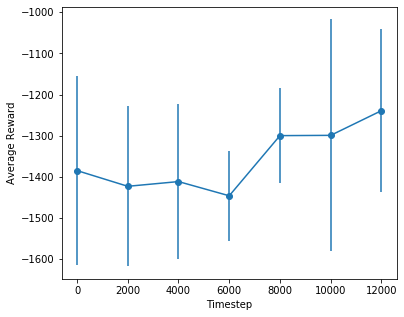

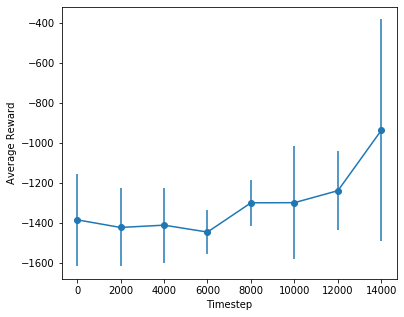

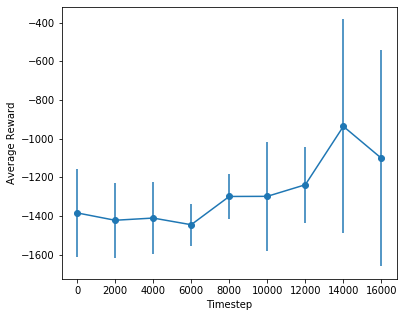

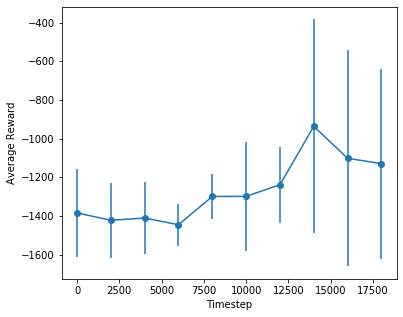

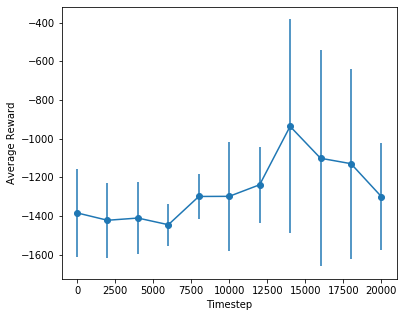

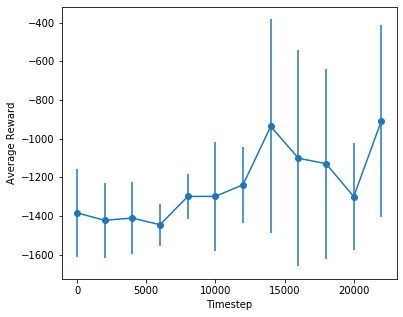

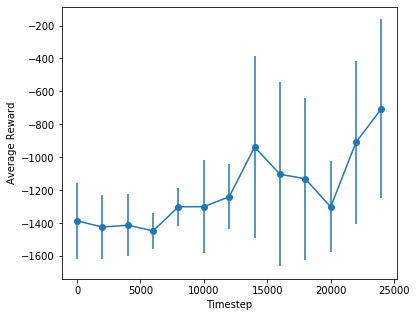

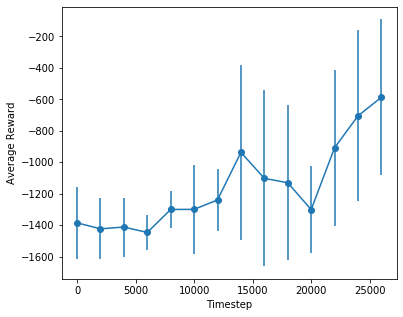

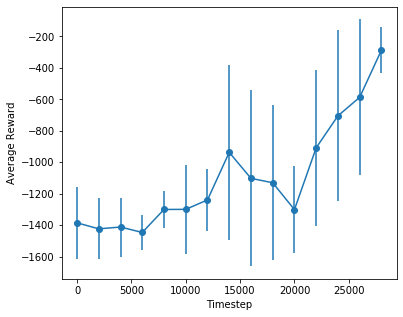

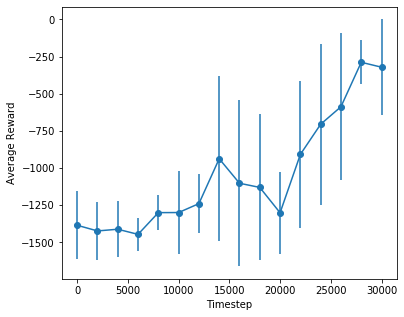

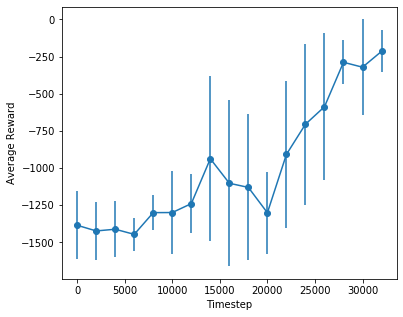

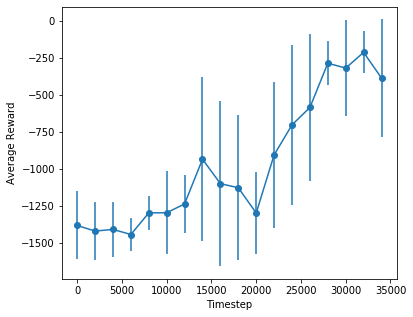

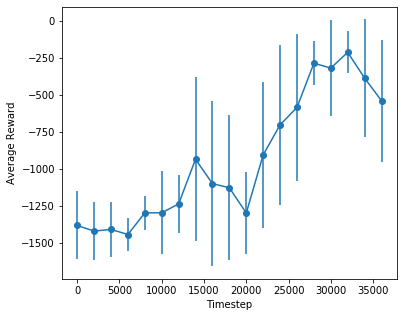

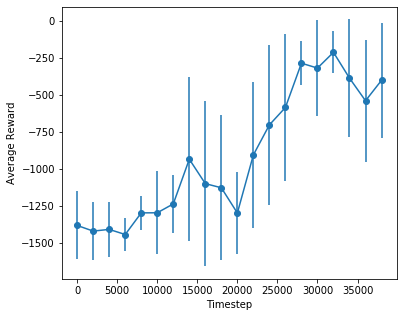

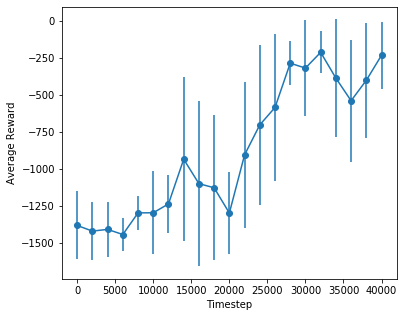

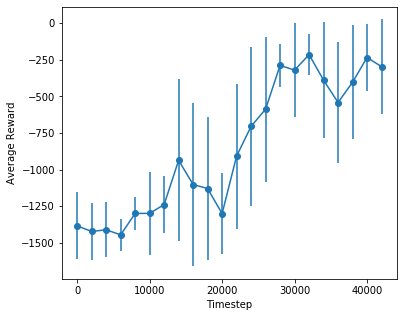

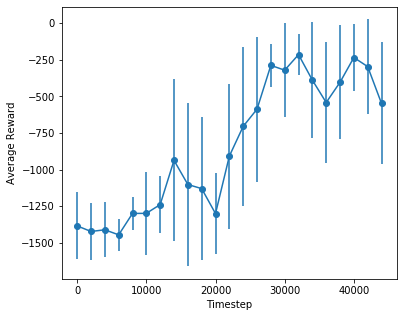

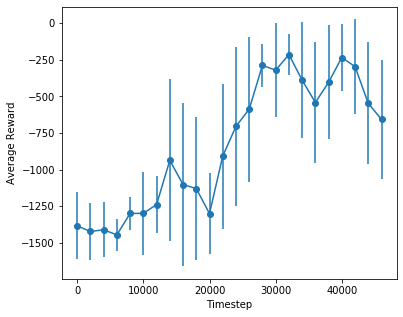

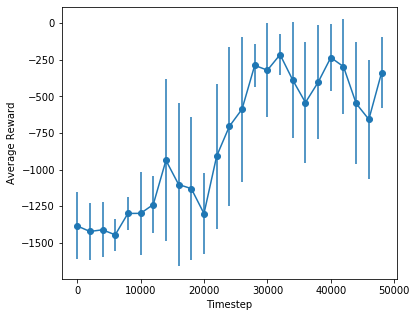

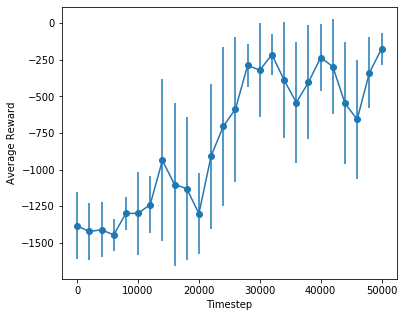

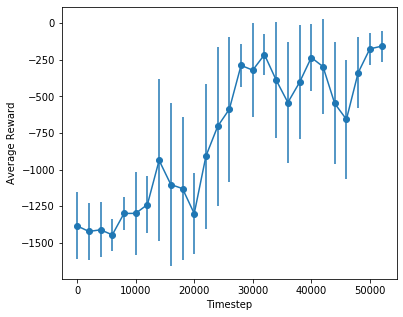

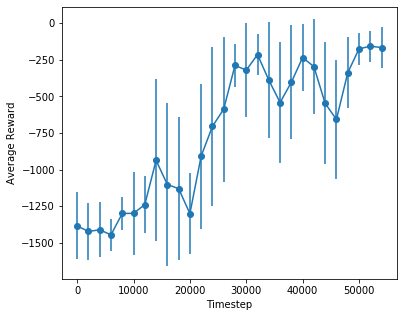

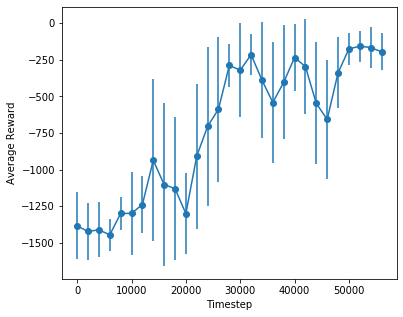

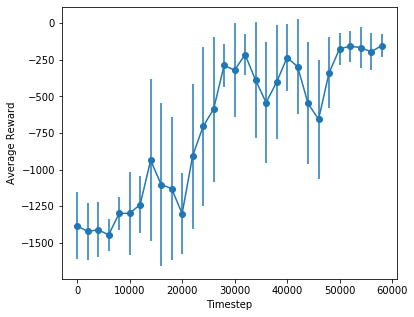

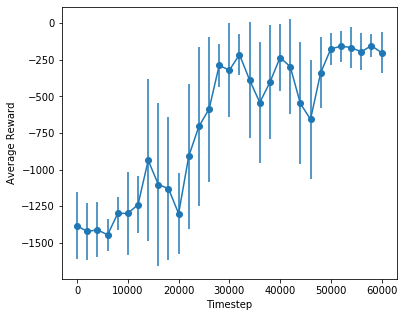

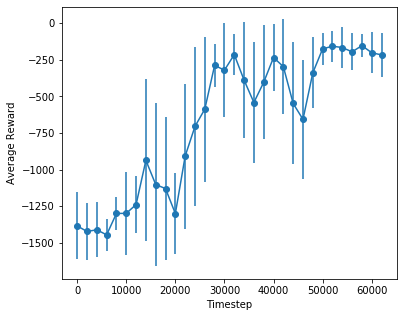

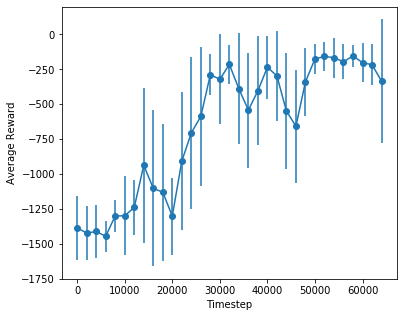

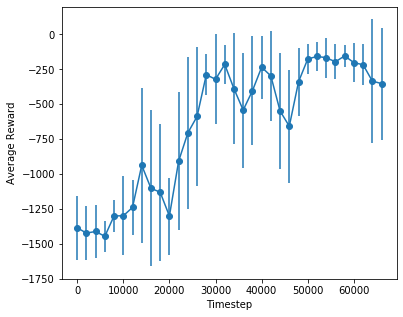

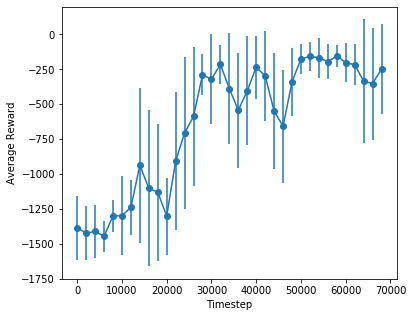

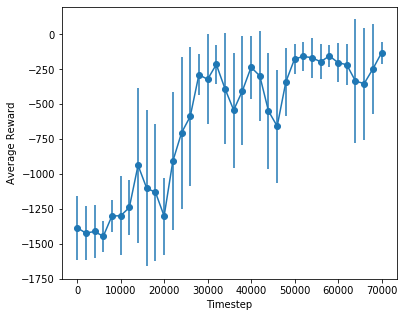

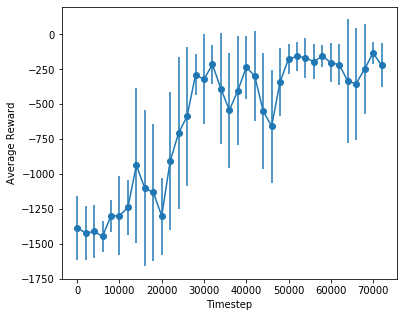

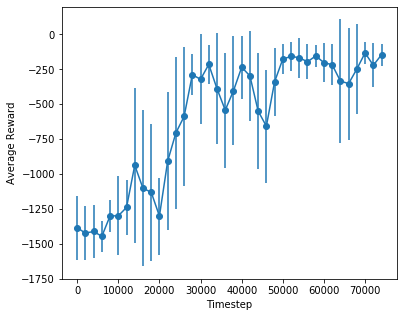

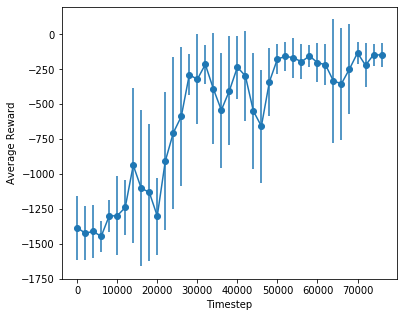

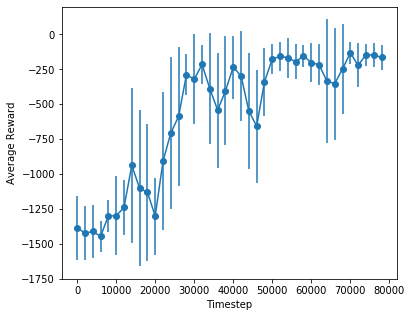

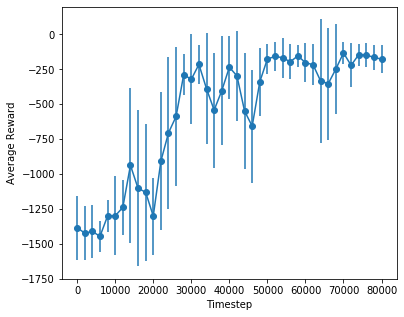

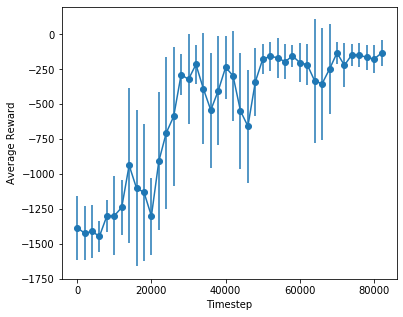

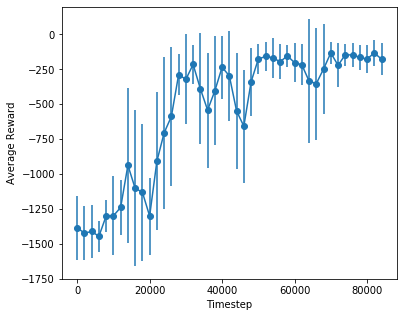

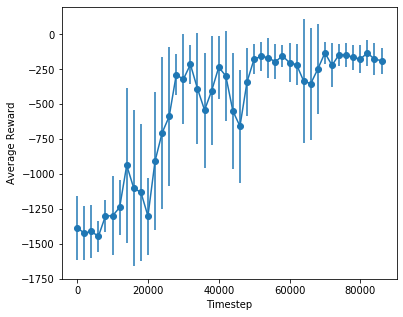

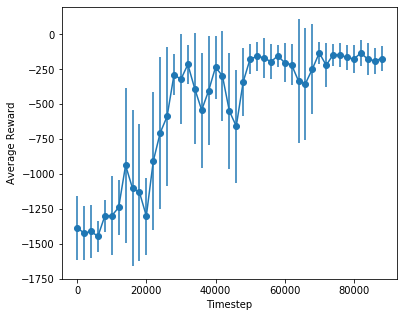

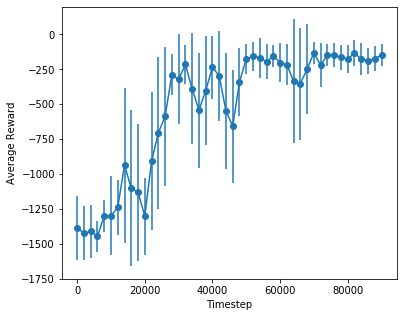

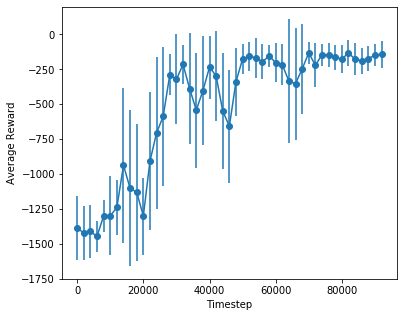

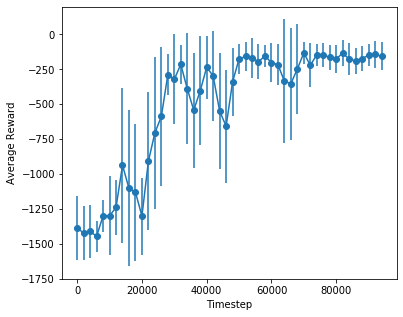

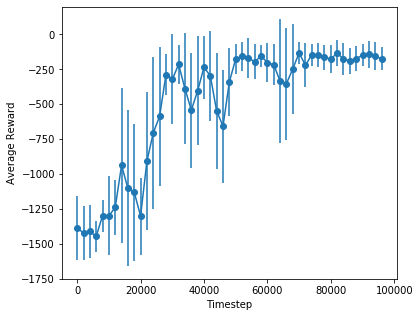

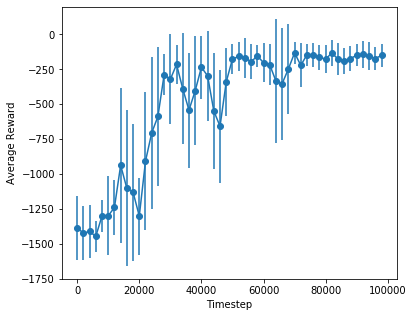

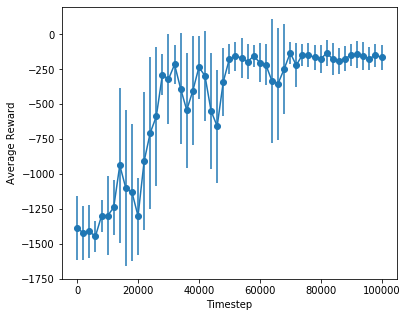

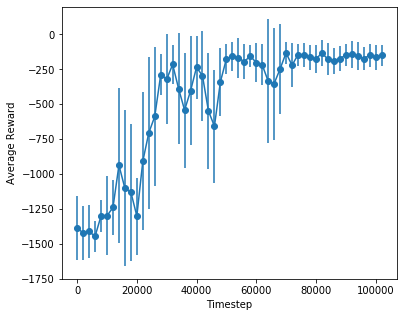

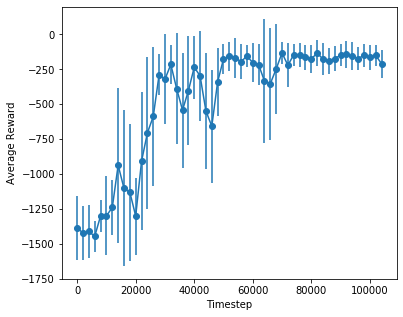

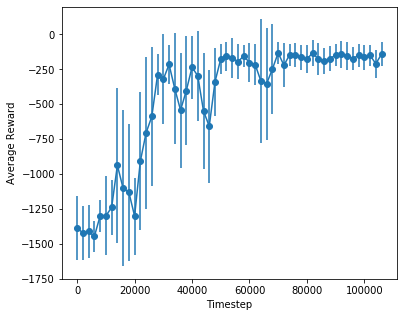

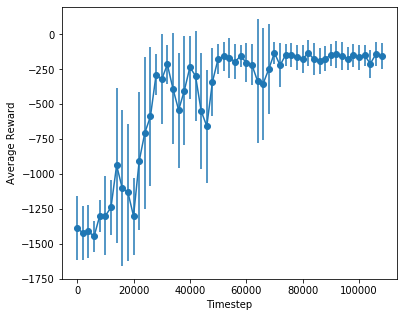

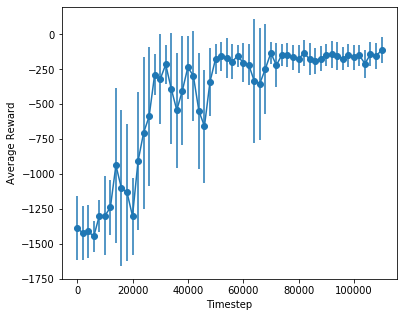

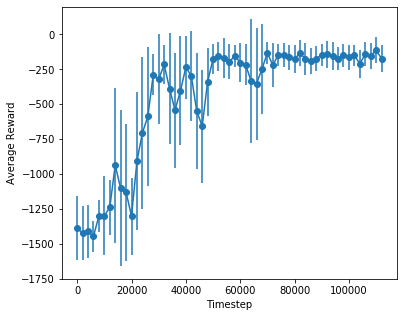

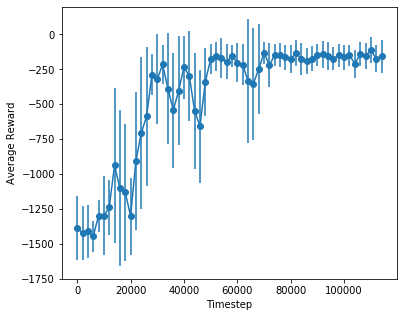

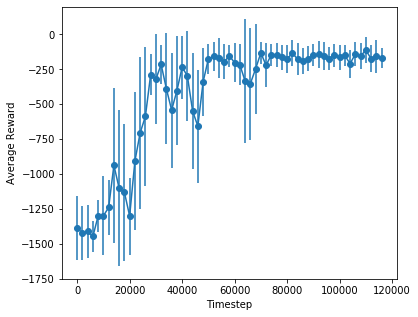

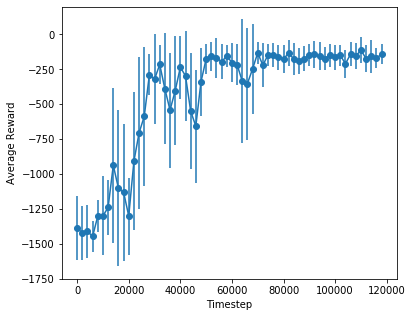

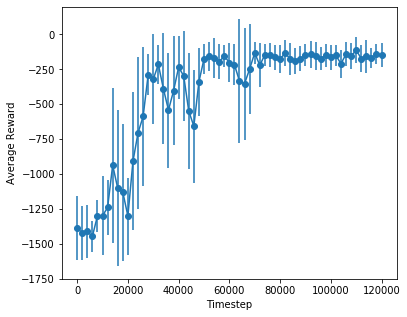

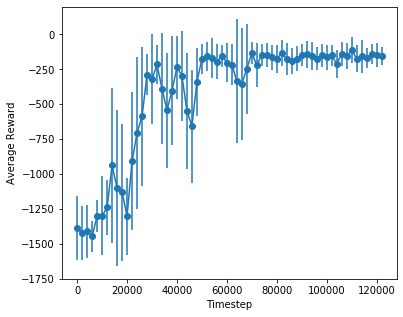

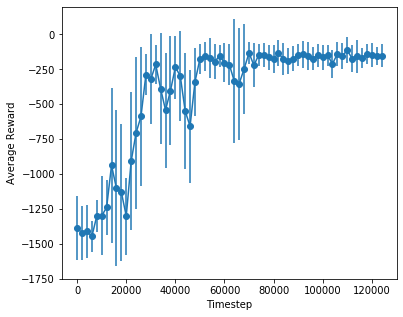

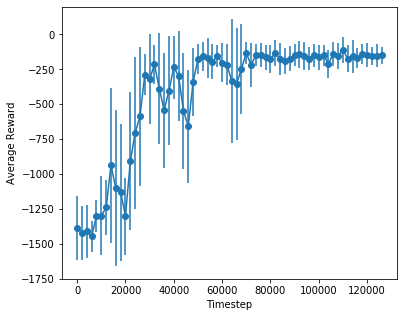

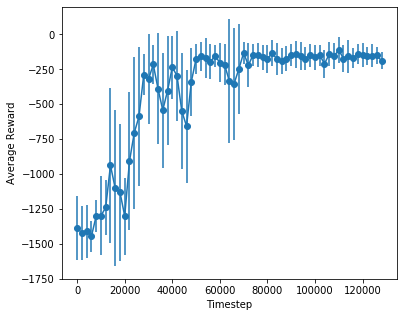

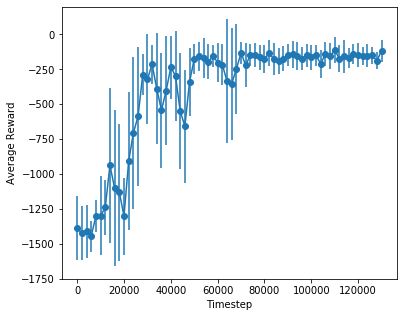

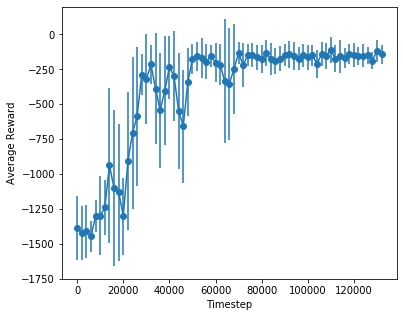

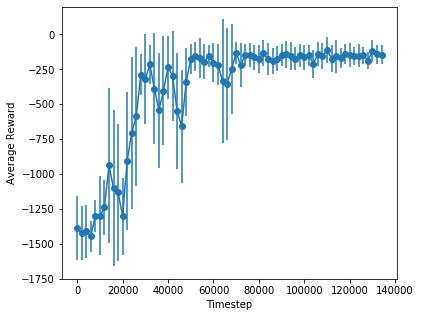

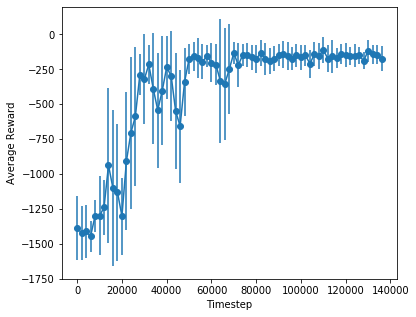

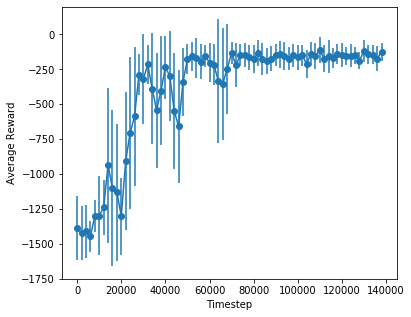

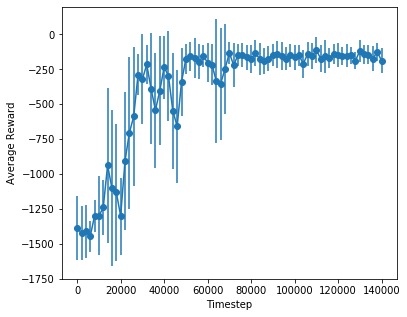

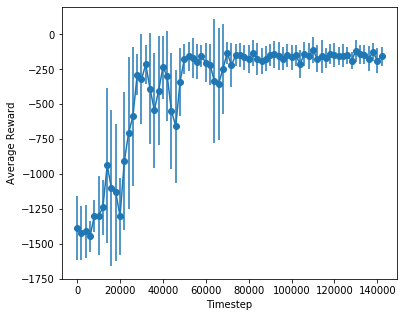

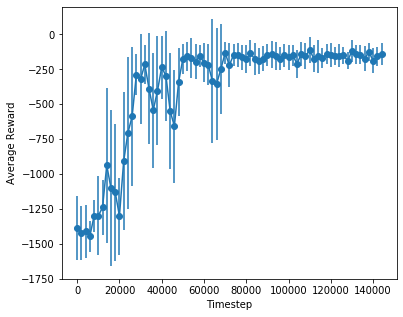

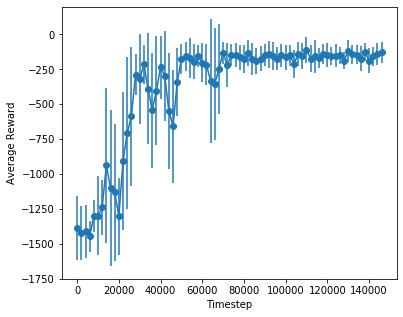

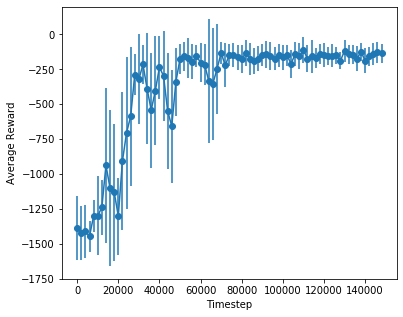

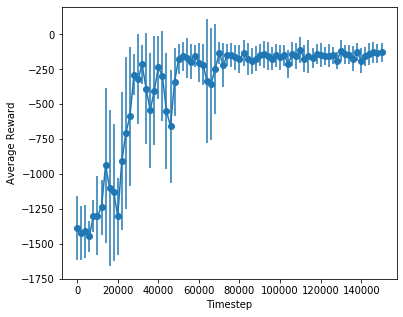

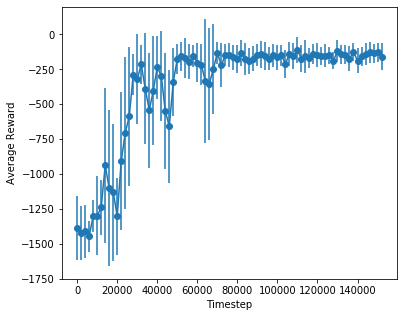

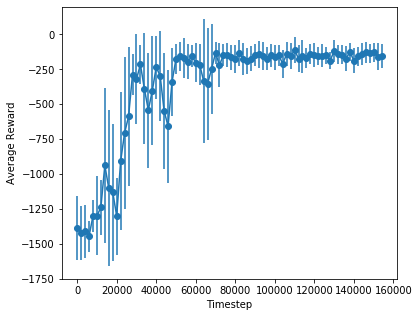

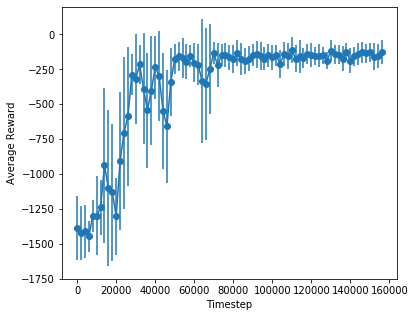

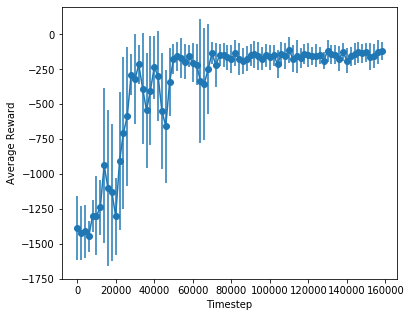

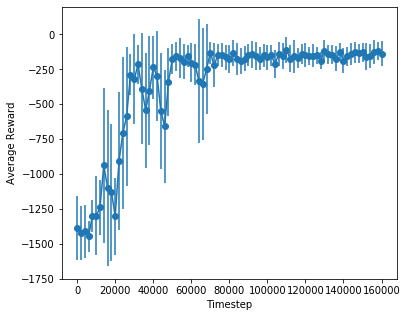

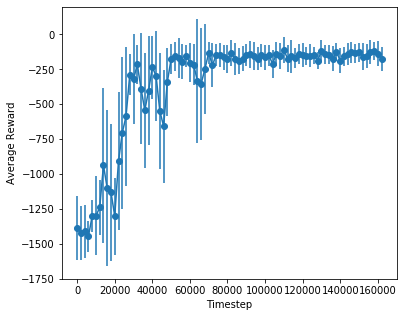

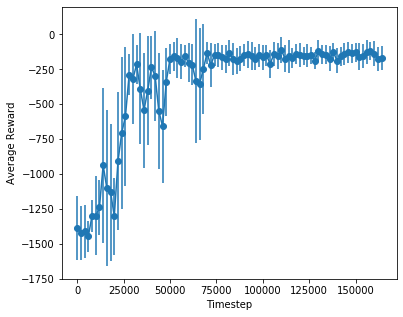

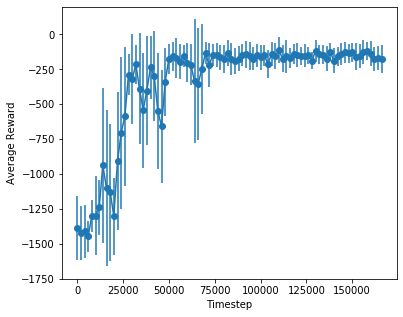

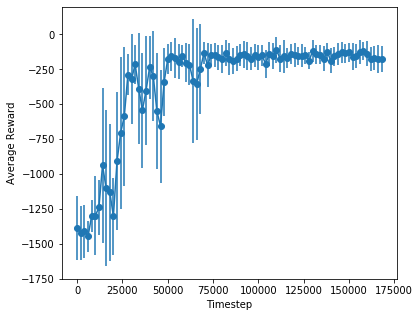

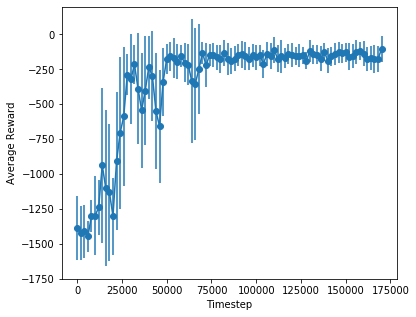

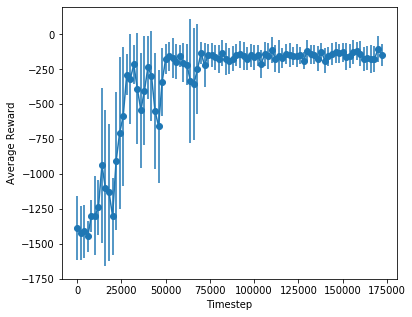

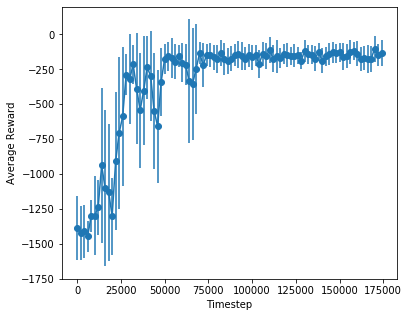

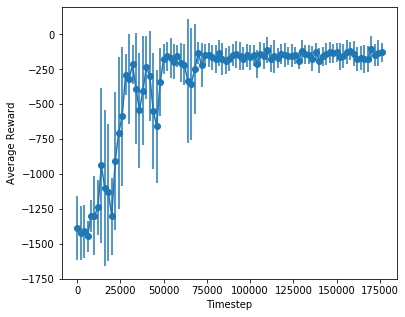

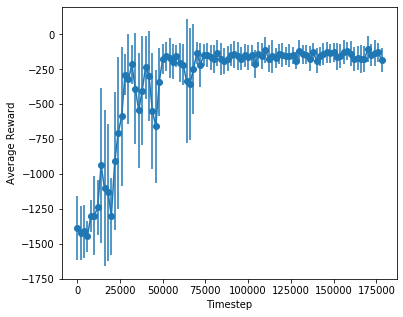

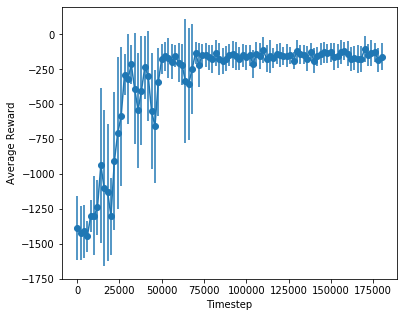

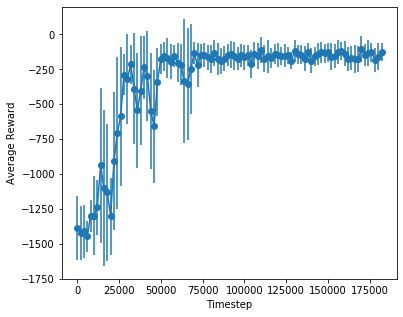

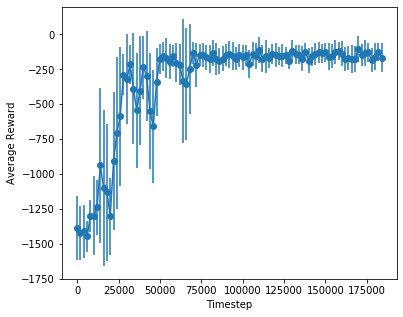

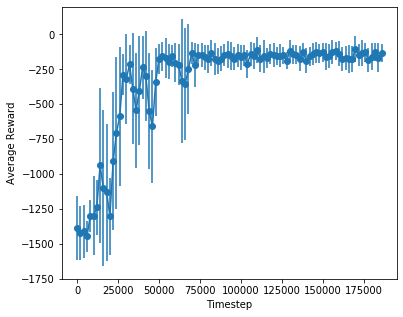

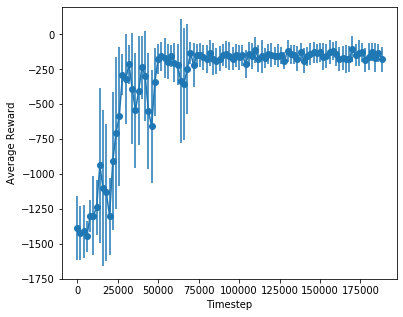

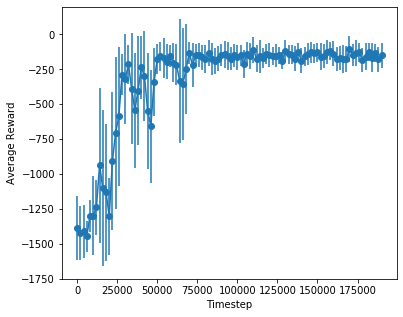

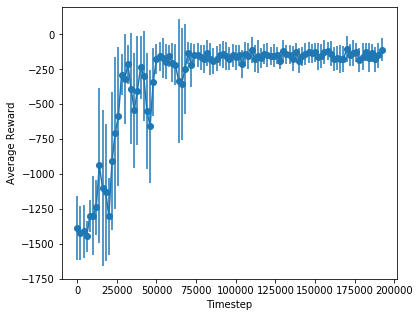

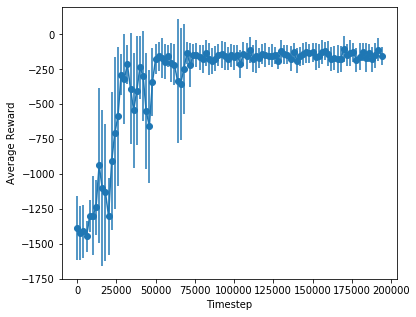

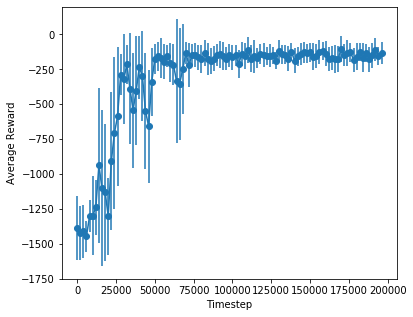

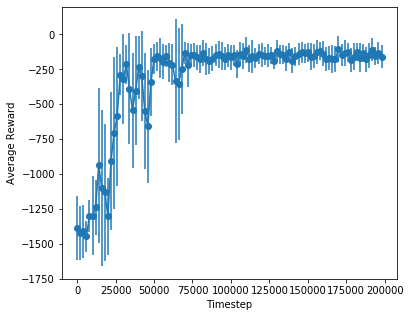

In [22]:
train(
    args.train_iter, 
    agent, 
    env, 
    evaluate, 
    args.validate_steps, 
    args.output, 
    max_episode_length=args.max_episode_length, 
    debug=args.debug
)